In [1]:
# we set a random seed here to make the results in this notebook reproducible
import random
import numpy as np

my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

# Evaluating Recommender Systems

The evaluation of recommender systems follows the same paradigm found in general machine learning. We need a development set that we use for training algorithms and evaluating changes in hyperparameter settings, either via a holdout split or cross-validation. Finally, we need a test set that was neither part of training nor parameter optimization for an unbiased evaluation of our recommender system.

By default the Surprise library supports RMSE(Root Mean Squared Error), MSE(Mean Squared Error) and MAE(Mean Absolute Error) as known from the lecture. The following cell demonstrates how we can create a train/test split for the MovieLens dataset, train a KNNBasic user-based recommender and subsequently evaluate its performance on the test set.

We will once gain use the [**MovieLens-100k**](https://grouplens.org/datasets/movielens/) dataset we already saw in the last exercise. This time we will load the dataset from local files as we will later want to make use of content features of the movies which are not available when using the dataset auto loading function in surprise. In the project you can use the same loading function for your own datasets.

In [11]:
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split

import pandas as pd
import numpy as np

## Load movies data
movies = pd.read_csv('ml-latest-small/movies.csv')
#tags = pd.read_csv('ml-latest-small/tags.csv') # Optionally add tags
ratings = pd.read_csv('ml-latest-small/ratings.csv', dtype= {'userId': str, 'movieId': str})
links = pd.read_csv('ml-latest-small/links.csv')
display(ratings.head())

# Load data into dataset
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Holdout Splits for Evaluation

Similar to the train_test split function from scikit-learn, the surprise package offers a [train_test_split method](https://surprise.readthedocs.io/en/stable/model_selection.html#surprise.model_selection.split.train_test_split). The splitting is done randomly. The following example splits 25% of ratings into the test fold.

In [12]:
from pdb import set_trace

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=0.25, random_state=my_seed)

# Define a custom similarity function for the KNNBasic algorithm
sim_options = {'name': 'pearson', 'user_based': True, 'min_support': 1}

algo = KNNBasic(sim_options=sim_options)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


### Numerical Evaluation

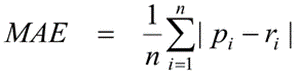

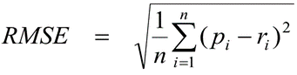

The numerical ratings (Root) Mean Squared Error (MSE, RMSE) and Mean Absolute Error (MAE) are implemented in the [accuracy package](https://surprise.readthedocs.io/en/stable/accuracy.html) of the surprise library and can directly be calculated:

In [13]:
from surprise.accuracy import mse, rmse, mae
# Compute MSE, RMSE and MAE on the test set predictions
mse(predictions)
rmse(predictions)
mae(predictions);

MSE: 0.9390
RMSE: 0.9690
MAE:  0.7481


### Categorical Evaluation


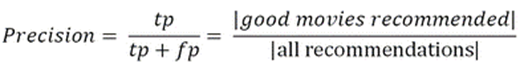

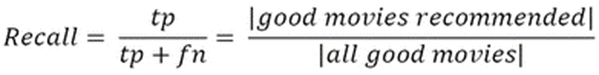

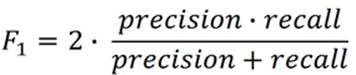

Categorical Ratings, well known from Data Mining, like **Precision**, **Recall** and **F1** are not directly implemented in the Surprise library. But we can gather the relvant information ourselves and calculate the measures. It is important to note that we have to set a manual rating threshold to indicate when a movie is actually relevant for a user. Setting a global rating as we do in the following example is a very simple approach which does not take different rating-behaviour of users into account.

In [14]:
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def precision_recall_f1(predictions, threshold=3.5):
    """Return precision, recall and f1 metrics averaged across all users"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    # collect metrics per user
    precisions = dict()
    recalls = dict()
    f1s = dict()
    accuracies = dict()
    
    for uid, user_ratings in user_est_true.items():
        
        # get relevance labels for average precision calculation
        y_true = [1 if (true_r >= threshold) else 0 for (_, true_r) in user_ratings]
        y_pred = [1 if (est_r >= threshold) else 0 for (est_r, _) in user_ratings]
        
        precisions[uid] = precision_score(y_true, y_pred, zero_division=0)
        recalls[uid] = recall_score(y_true, y_pred, zero_division=0)
        f1s[uid] = f1_score(y_true, y_pred, zero_division=0)

        accuracies[uid] = accuracy_score(y_true, y_pred)

    # average scores over all users 
    avg_precision = sum(list(precisions.values())) / len(list(precisions.values()))
    avg_recall = sum(list(recalls.values())) / len(list(recalls.values()))
    avg_f1 = sum(list(f1s.values())) / len(list(f1s.values()))
    
    avg_accuracy = sum(list(accuracies.values())) / len(list(accuracies.values()))
    
    return avg_precision, avg_recall, avg_f1, avg_accuracy

In [15]:
# get average evaluation measures and print them
avg_precision, avg_recall, avg_f1, avg_accuracy = precision_recall_f1(predictions, threshold=3.5)
print(f'Avg. Precision: {avg_precision}')
print(f'Avg. Recall: {avg_recall}')
print(f'Avg. F1: {avg_f1}')
print(f'Avg. Accuracy: {avg_accuracy}')

Avg. Precision: 0.7340483684425808
Avg. Recall: 0.7227663637153214
Avg. F1: 0.7036871120873112
Avg. Accuracy: 0.6701322626336957


### Rank-based Evaluation

In real-world use-cases just evaluating on all recommended items may severly overestimate the performance of a recommender system as the user is usually presented with a ranked list of recommendations. If the relevant items are recommended but appear at the bottom of the list, this can be misleading as people do not usually scroll through all the recommendations.

To incorporate the rank of an item we can make use of rank based evaluation metrics like Average Precision (AP), Precision@k, R-Precision and nDCG

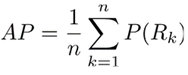

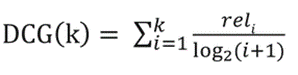

In [16]:
from sklearn.metrics import average_precision_score, ndcg_score

def measures_at_k(predictions, k=10, threshold=3.5):
    """Return precision and nDCG at k metrics averaged across all users"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    average_precisions = dict()
    precisions_at_k = dict()
    ndcgs_at_k = dict()

    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        # get relevance labels for average precision calculation
        y_true = [1 if (true_r >= threshold) else 0 for (_, true_r) in user_ratings]
        y_pred = [1 if (est_r >= threshold) else 0 for (est_r, _) in user_ratings]
        
        y_true_at_k = y_true[:k]
        y_pred_at_k = y_pred[:k]
        
        if sum(y_true) > 0:
            average_precisions[uid] = average_precision_score(y_true, y_pred)
        else:
            average_precisions[uid] = 0

        precisions_at_k[uid] = precision_score(y_true_at_k, y_pred_at_k, zero_division=0)
        
        if not len(user_ratings) == 1:
            ndcgs_at_k[uid] = ndcg_score(np.asarray([[x for (_, x) in user_ratings]]), np.asarray([[x for (x, _) in user_ratings]]), k=k)
        elif len(user_ratings) == 1:
            ndcgs_at_k[uid] = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings
        )
            
        # compute simple averages over all users for each score:
        avg_average_precisions = sum(val for val in average_precisions.values()) / len(average_precisions)
        avg_precisions_at_k = sum(val for val in precisions_at_k.values()) / len(precisions_at_k)
        avg_ndcgs_at_k = sum(val for val in ndcgs_at_k.values()) / len(ndcgs_at_k)

    return avg_average_precisions, avg_precisions_at_k, avg_ndcgs_at_k

In [17]:
# get average evaluation measures and print them
avg_average_precisions, avg_precisions, avg_ndcgs = measures_at_k(predictions, k=5, threshold=3.5)
print(f'Avg. AveragePrecision: {avg_average_precisions}')
print(f'Avg. Precision@5: {avg_precisions}')
print(f'Avg. nDCG@5: {avg_ndcgs}')

Avg. AveragePrecision: 0.7174516127478939
Avg. Precision@5: 0.7884699453551931
Avg. nDCG@5: 0.8744889687841513


# Model-based Recommender Systems

The [SVD](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD) algorithm was popularized during the Netflix competition and is based on matrix factorization. The predicition is set as:

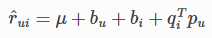

The method applies stochastic gradient descent to minimize the regularized squared error:

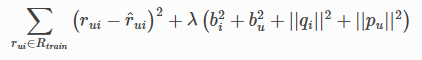

Due to stepwise gradient-descent based optimization the method offers a lot of hyperparameters like number of epochs, learning rate, etc.

In [18]:
from surprise import SVD

algo = SVD(n_epochs=10, lr_all=0.005, reg_all=0.4)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute MSE, RMSE and MAE
mse(predictions)
rmse(predictions)
mae(predictions);

MSE: 0.7859
RMSE: 0.8865
MAE:  0.6866


# Content-based Recommender Systems

All previously applied methods are collaborative methods and do not take the actual content of the items into account. Usually collaborative recommenders work better when a lot of ratings are available but consider the case where a new movie is introduced to the selection of a streaming company for which no ratings are available yet (cold-start problem). In such cases it can be useful to base recommendations for this movie on content features, e.g. recommend a new Star Wars movie to people that have watched previous installments or are generally interested in the genre.

Surprise does not support content-based recommendation by default, but we can extend it and implement our own algorithm.

In [19]:
from gensim.utils import tokenize
# Prepare Content
movies['content'] = movies['title'] + ' ' + movies['genres'].str.replace('|', ' ', regex=False)
movie_content_dict = dict(zip(movies['movieId'], movies['content']))

# Add content to trainset to parse the content of the movies to the trainset
#Convert content to list - Make sure that starting from 0 to the highest movieId a content entry exists in the list
trainset.content = [movie_content_dict[key] if key in movie_content_dict else '' for key in range(0, max(movie_content_dict.keys()))]

In [20]:
# Content-based Prediction using the Gensim library
from surprise import AlgoBase, Dataset, PredictionImpossible
from surprise.model_selection import cross_validate
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.similarities import SparseMatrixSimilarity

class ContentKNN(AlgoBase):
    def __init__(self,k=5):

        # Always call base method before doing anything.
        AlgoBase.__init__(self)
        self.k=k
    
    def fit(self, trainset):

        # Here again: call base method before doing anything.
        AlgoBase.fit(self, trainset)
        
        # Tokenize content by whitespace
        tokenized_content = [list(tokenize(line)) for line in trainset.content]
        
        # Compute TF-IDF Similarity Matrix
        dct = Dictionary(tokenized_content)  # fit dictionary
        self.corpus = [dct.doc2bow(line) for line in tokenized_content]
        self.model = TfidfModel(self.corpus)
        
        # Prepare Index
        self.index = SparseMatrixSimilarity(self.model[self.corpus], num_features=len(dct))

        return self
    
    
    def estimate(self, u, i):
        
        # The user must be "known" as we need at least 1 rated item to make a recommendation
        if self.trainset.knows_user(u):
            # Get user ratings
            user_ratings = self.trainset.ur[u]
            
            # if an item is not "known" to the training set (cold-start) we still can
            # make a prediction with the content-based recommender
            if type(i) is str:
                i = int(i.replace('UKN__', '')) - 1
                
            # Get similarities
            similarities = self.index[self.corpus[i]]
 
            # Filter user similarity scores by number of nearst neighbours and threshold > 0
            sim_user_dict = {user_rating[0]: similarities[user_rating[0]] for user_rating in user_ratings}
            sorted_filtered_sim = sorted(list(sim_user_dict.values()), reverse=True)[0:self.k]
            sim_user_dict = {user: sim for user, sim in sim_user_dict.items() if sim > 0 and sim in sorted_filtered_sim}
            
            #Simple prediction
            if len(sim_user_dict) > 0:
                rating = sum([sim_user_dict[user_rating[0]]*user_rating[1] for user_rating in user_ratings if user_rating[0] in sim_user_dict])/\
                            sum([sim_user_dict[user_rating[0]] for user_rating in user_ratings if user_rating[0] in sim_user_dict])
            else:
                raise PredictionImpossible("No similar items found.")
        else:
            raise PredictionImpossible("User is unknown.")
            
        
        return rating

Subsequently we can use the Content-based recommender the same way as any other surprise algorithm

In [21]:
algo = ContentKNN(k=5)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute MSE, RMSE and MAE
mse(predictions)
rmse(predictions)
mae(predictions);

MSE: 1.0619
RMSE: 1.0305
MAE:  0.8012


## Cold-start problem
Content-based recommender have an advantage over collaborative filtering based approaches, because they can predict ratings for items that have not been rated, yet.

In [22]:
# Cold-start problem
uid = str(28)
iid = str(1572) # This item has not been rated

algo = ContentKNN(k=5)

# Train the algorithm on the trainset, and predict ratings of a user for an item that has no ratings in the training set
algo.fit(trainset)
pred = algo.predict(uid, iid, r_ui=2.5, verbose=True)


algo = KNNBasic(sim_options=sim_options)

# Train the algorithm on the trainset, and predict ratings of a user for an item that has no ratings in the training set
algo.fit(trainset)
pred = algo.predict(uid, iid, r_ui=2.5, verbose=True)

user: 28         item: 1572       r_ui = 2.50   est = 2.73   {'was_impossible': False}
Computing the pearson similarity matrix...
Done computing similarity matrix.
user: 28         item: 1572       r_ui = 2.50   est = 3.50   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


# Hybrid Recommender Systems

Content-based recommenders often work better when there are few ratings available for a user or item. On the other hand, collaborative recommenders work really well when there are a lot of similar users or similarly rated items. Since both cases are common in real-world use cases, it makes sense to build a hybrid recommender system that takes both types of recommendations into account.

A simple way to combine different types of recommender systems can be achieved by simply averaging the respective recommended ratings of each recommender. The following cell implements such a hybrid using collaborative filtering with KNNBasic and our self-implemented content-based recommender.

In [23]:
class ContentKNNBasicHybrid(AlgoBase):
    def __init__(self, k=5, name='pearson', user_based=True, min_support=1):

        # Always call base method before doing anything.
        AlgoBase.__init__(self)
        self.k = k
        self.name = name
        self.user_based = user_based
        self.min_support = min_support
    
    def fit(self, trainset):

        # Here again: call base method before doing anything.
        AlgoBase.fit(self, trainset)
        
        self.content = ContentKNN(k=5)
        self.content.fit(trainset)
        
        sim_options = {'name': self.name, 'user_based': self.user_based, 'min_support': self.min_support}
        self.knn = KNNBasic(sim_options=sim_options)
        self.knn.fit(trainset)

        return self
    
    
    def estimate(self, u, i):
        # Implement estimation

        if self.trainset.knows_user(u):
            r_content = self.content.estimate(u, i)
            r_knn = self.knn.estimate(u, i)

            #Simple prediction using the average of both ratings
            rating = (r_content + r_knn[0]) / 2
        else:
            raise PredictionImpossible("User is unknown.")
            
        return rating

In [24]:
algo = ContentKNNBasicHybrid(k=5, name='pearson', user_based=True, min_support=1)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute MSE, RMSE and MAE
mse(predictions)
rmse(predictions)
mae(predictions);

Computing the pearson similarity matrix...
Done computing similarity matrix.
MSE: 0.9080
RMSE: 0.9529
MAE:  0.7404


Comparing these results to the previous results of the KNNBasic and Content-based recommenders in isolation, we can clearly see an improvement across all three numerical measures.

KNNBasic:
MSE: 0.9390
RMSE: 0.9690
MAE:  0.7481

Content:
MSE: 1.0619
RMSE: 1.0305
MAE:  0.8012

Hybrid:
MSE: 0.9080
RMSE: 0.9529
MAE:  0.7404

# Generation of example recommendations for a user

We now know how to evaluate recommendations across our dataset quantitatively, but how can we actually print some recommendations for an example user based on the testset and compare this with their truly watched movies sorted by rating?

In [25]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [26]:
top_n = get_top_n(predictions, n=5)

# Let's get recommendations for user 196
uid = str(196)

# collect all movies the user rated
user_movies = ratings[ratings['userId'] == int(uid)]

# get the recommendations for the specific user from the top_n dict
recommendations = [movies[movies['movieId'] == int(iid)]['title'].iloc[0] for (iid, _) in top_n[uid]]

print('Top 5 recommendations for user with id 196:')
for i, rec in enumerate(recommendations):
    print(f'{i+1} {rec}')

Top 5 recommendations for user with id 196:
1 Lord of the Rings: The Two Towers, The (2002)
2 Alien (1979)
3 Mr. Holland's Opus (1995)
4 Pianist, The (2002)
5 Up (2009)


We can compare these recommendations with the actual movies found in the testset for that user ranked by rating

In [27]:
# First we collect all movies the user rated and filter them down to only those appearing in the test set
user_movies = ratings[ratings['userId'] == uid].sort_values(by='rating', ascending=False)
movies_relevant = []
for user, movie, rating in testset:
    if user == uid:
        movies_relevant.append(movies[movies['movieId'] == int(movie)]['title'].iloc[0])

for movie in movies_relevant:
    print(movie)

Mr. Holland's Opus (1995)
Up (2009)
Pianist, The (2002)
Lord of the Rings: The Two Towers, The (2002)
Alien (1979)
The Martian (2015)


# Hyperparameter estimation via GridSearch

As in data mining, the recommendation pipeline/model may have certain hyperparameters that need to be set by the user independently of the training process. As the evaluation setup is very similar to the data mining model learning phase, we can apply the same ideas here, for example, perform an automated hyperparameter search using Gridsearch with cross-validation on our training split.

In the following cell, we perform a Gridsearch with cross-validation on the training set to optimise the SVD algorithm and then retrain the model on the full training set with the best found parameters and perform an unbiased evaluation on a withheld test set.

In [28]:
import random
from surprise.model_selection import GridSearchCV

raw_ratings = data.raw_ratings

# shuffle ratings if you want
random.shuffle(raw_ratings)

# A = 80% of the data, B = 20% of the data
threshold = int(0.8 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

data.raw_ratings = A_raw_ratings  # data is now the set A

param_grid = {"n_epochs": [5, 10], "lr_all": [0.002, 0.005], "reg_all": [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=3)

gs.fit(data)

# best RMSE score

print(f'Best validation score: {gs.best_score["rmse"]}')

# combination of parameters that gave the best RMSE score
print(f'Best found parameter setting: {gs.best_params["rmse"]}')

# Retrain on full train set with best settings
algo = gs.best_estimator["rmse"]
# retrain on the whole set A
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on A
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on the full training set,", end="   ")
rmse(predictions)

# Compute unbiased accuracy on B
testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
predictions = algo.test(testset)
print("Unbiased accuracy on the test set,", end=" ")
rmse(predictions);

Best validation score: 0.898470703958668
Best found parameter setting: {'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}
Biased accuracy on the full training set,   RMSE: 0.8574
Unbiased accuracy on the test set, RMSE: 0.8897
